In [ ]:
import pandas as pd
import mysql.connector
import os


# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:\projects\Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "1234",
                             database = "ecommerce")
cur = db.cursor()


# List all unique cities where customers are located.

In [14]:
query = """ select distinct customer_city from customers """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["unique_cities"])
df.head()

,unique_cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [13]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017", data[0][0]

('total orders placed in 2017', 180404)

# Find the total sales per category

In [12]:
query = """ select upper(products.product_category) category, round(sum(payments.payment_value),2) sales
from products join order_items
on products .product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category","sales"])
df.head()

,category,sales
0,PERFUMERY,1520215.98
1,FURNITURE DECORATION,4290529.18
2,TELEPHONY,1460646.15
3,BED TABLE BATH,5137661.01
4,AUTOMOTIVE,2556882.99


# Calculate the percentage of orders that were paid in installments

In [11]:
query = """ select (sum(case when payment_installments >=1 then 1 else 0 end)) /count(*)*100
from payments """

cur.execute(query)
data = cur.fetchall()
"percentage of orders that were paid in installments is",data[0][0]

('percentage of orders that were paid in installments is', Decimal('99.9981'))

# Count the number of customers from each state.

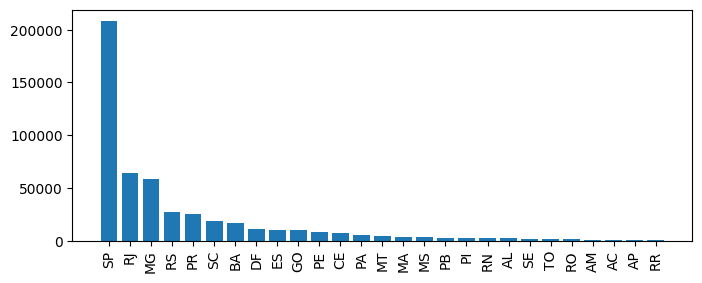

In [10]:
query = """ select customer_state,count(customer_id)
from customers
group by customer_state """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["state","customer_count"])
df  =df.sort_values(by = 'customer_count',ascending =  False)
plt.figure(figsize = (8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation = 90)
plt.show()

# Calculate the number of orders per month in 2018

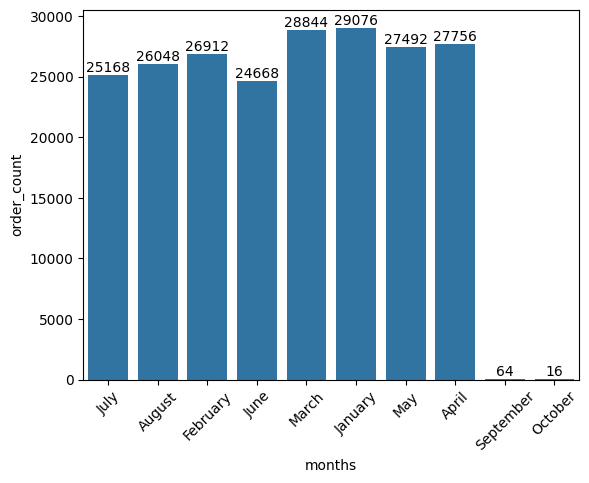

In [9]:
query = """ select monthname(order_purchase_timestamp) months ,count(order_id) count_order
from orders
where year(order_purchase_timestamp) = 2018
group by months """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["months","order_count"])
ax = sns.barplot(x =df["months"],y =df["order_count"],data = df)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.show()

#  Find the average number of products per order, grouped by customer city.


In [8]:
query = """ With count_per_order as
(select orders.order_id,orders.customer_id,count(order_items.order_id)as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)
select customers.customer_city,round(avg(count_per_order.oc),2)average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["customer_city","average_order"])
df.head(10)

,customer_city,average_order
0,treze tilias,5.09
1,indaial,4.46
2,sao jose dos campos,4.55
3,sao paulo,4.62
4,porto alegre,4.70
5,santos,4.65
6,sao francisco do sul,4.94
7,sao vicente,4.36
8,joinville,4.41
9,sao vendelino,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [6]:
query = """select upper(products.product_category) category, round((sum(payments.payment_value)/(select sum(payment_value)from payments))*100,2) sales_percentage
from products join order_items
on products .product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc; """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category","percentage distribution"])
df                  

                

,category,percentage distribution
0,BED TABLE BATH,32.09
1,HEALTH BEAUTY,31.06
2,COMPUTER ACCESSORIES,29.71
3,FURNITURE DECORATION,26.80
4,WATCHES PRESENT,26.78
...,...,...
69,PC GAMER,0.04
70,HOUSE COMFORT 2,0.03
71,CDS MUSIC DVDS,0.02
72,FASHION CHILDREN'S CLOTHING,0.01


# Identify the correlation between product price and the number of times a product has been purchased.


In [7]:
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category","order_count","price"])
arr = df["order_count"]
arr1 = df["price"]
np.corrcoef([arr,arr1])


array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue.

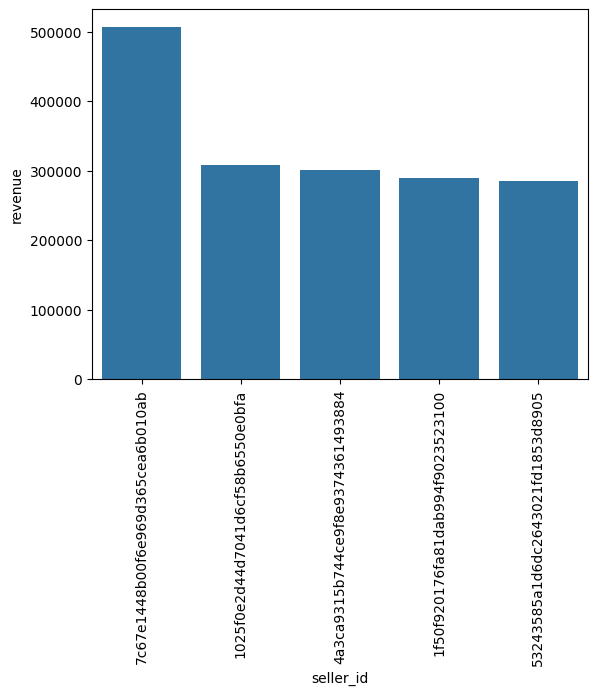

In [5]:
query = """select * , dense_rank() over(order by revenue desc ) as rn from 
(select order_items.seller_id,sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["seller_id","revenue","rank"])
df = df.head()
sns.barplot(x = "seller_id",y = "revenue",data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.


In [6]:
query = """select distinct(customer_id),order_purchase_timestamp,payment,
avg(payment)over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row)as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["cust_id","o_p_t","payment","mov_avg"])
df = df.head()
df

,cust_id,o_p_t,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# Calculate the cumulative sales per month for each year.

In [7]:
query = """ select years, months, payment ,sum(payment)
over(order by years , months ) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id =  payments.order_id
group by years , months order by years , months) as a;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years","months","payment","cumulative_sales"])
df = df.head()
df

,years,months,payment,cumulative_sales
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56


# Calculate the year-over-year growth rate of total sales.

In [10]:
query = """  with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id =  payments.order_id
group by years  order by years)
select years,((payment-lag(payment,1)over(order by years))/
lag(payment,1) over(order by years))*100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years","yoy % growth"])
df = df.head()
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [8]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders 
on customers.customer_id = orders.customer_id
group by customers.customer_id),
b as (select a.customer_id , count(distinct orders.order_purchase_timestamp) next_order
from a  join orders 
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp <
date_add(first_order, interval 6 month)
group by a.customer_id)
select 100* (count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns =[ "customer"])
df

,customer
0,None


# Identify the top 3 customers who spent the most money in each year.

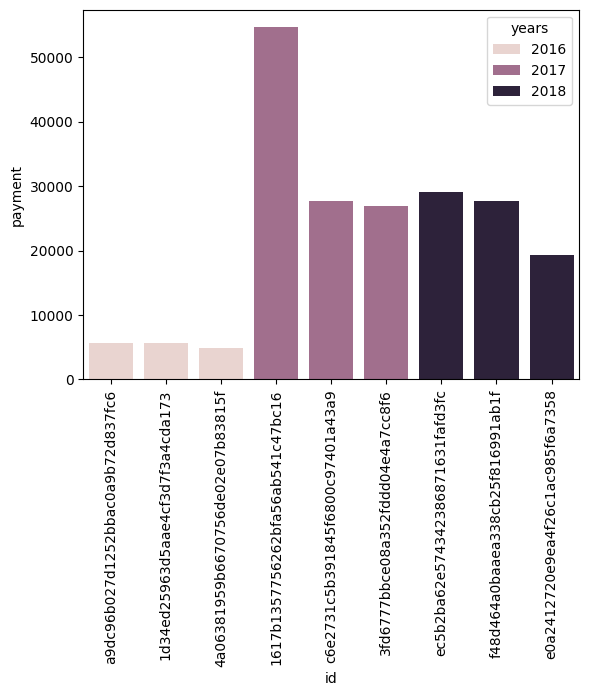

In [15]:
query = """select years,customer_id,payment,d_rank from
(select year(orders.order_purchase_timestamp)  years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) d_rank
from orders join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <=3;  """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years","id","payment","rank"])
sns.barplot(x = "id" , y = "payment",data= df ,hue= "years")
plt.xticks(rotation =  90)
plt.show()